In [1]:
from stage1 import *

In [2]:
nframes,natoms,nmols=(0,0,0)

In [3]:
from stage2 import *

In [4]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [5]:
testframe=md.load_xtc("../../xtc_files/eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [6]:
cf=condenseframe(testframe)

In [7]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [8]:
cf

array([[-0.75548023,  0.64079529, -0.49348218,  1.54600012,  0.0365    ,
         1.96000016],
       [-1.04095062,  0.19621834, -1.14165287,  1.77950013,  1.38899994,
         0.11775   ],
       [-0.80704082,  0.53351773, -0.62912294,  1.30550015,  1.17525005,
         1.73250008],
       ...,
       [-0.85465866,  1.10764374, -0.33165562,  2.32249999,  1.329     ,
         1.28500009],
       [-0.76587988,  0.60761498, -0.52716204,  1.852     ,  0.3775    ,
         1.35125017],
       [-0.77540491,  0.59042599, -0.55450055,  2.53500009,  2.49450016,
         2.10500002]])

In [9]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:03<00:00, 13.08it/s]

30192


In [10]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [11]:
g = get_graph(cf,1,n_neigh,"cry")

In [12]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [13]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 20
batch_size=32
test_train_split = 0.8
model_name = "model2.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [14]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:00<00:00, 75757.82it/s]


In [15]:
graphs = graphs_device
total_graphs = len(graphs)


In [16]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cpu
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 15
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(64, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 16, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [17]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [18]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [19]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [20]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 41.1651
	Test: 	MSE Loss: 24.8744
Epoch: 002
	Train:	MSE Loss: 22.3882
	Test: 	MSE Loss: 23.2962
Epoch: 003
	Train:	MSE Loss: 21.7509
	Test: 	MSE Loss: 21.8833
Epoch: 004
	Train:	MSE Loss: 20.3721
	Test: 	MSE Loss: 20.8507
Epoch: 005
	Train:	MSE Loss: 19.8986
	Test: 	MSE Loss: 20.4343
Epoch: 006
	Train:	MSE Loss: 19.6274
	Test: 	MSE Loss: 19.9163
Epoch: 007
	Train:	MSE Loss: 19.4287
	Test: 	MSE Loss: 19.7862
Epoch: 008
	Train:	MSE Loss: 19.2868
	Test: 	MSE Loss: 19.3694
Epoch: 009
	Train:	MSE Loss: 19.0752
	Test: 	MSE Loss: 19.0520
Epoch: 010
	Train:	MSE Loss: 18.6480
	Test: 	MSE Loss: 18.2742
Epoch: 011
	Train:	MSE Loss: 17.8652
	Test: 	MSE Loss: 17.2916
Epoch: 012
	Train:	MSE Loss: 16.9288
	Test: 	MSE Loss: 16.1660
Epoch: 013
	Train:	MSE Loss: 15.6002
	Test: 	MSE Loss: 15.1056
Epoch: 014
	Train:	MSE Loss: 14.7763
	Test: 	MSE Loss: 14.6301
Epoch: 015
	Train:	MSE Loss: 14.3459
	Test: 	MSE Loss: 14.2674
Epoch: 016
	Train:	MSE Loss: 13.9979
	Test: 	MSE Loss: 

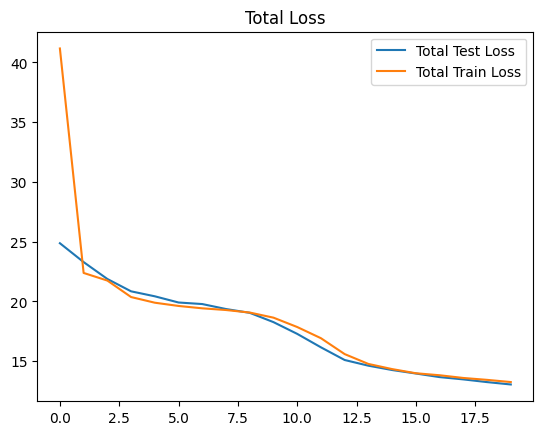

In [21]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

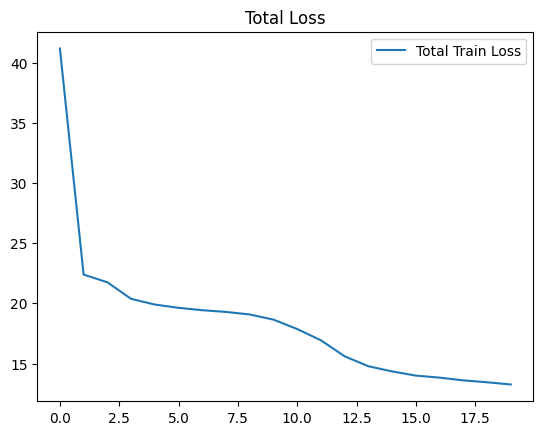

In [22]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

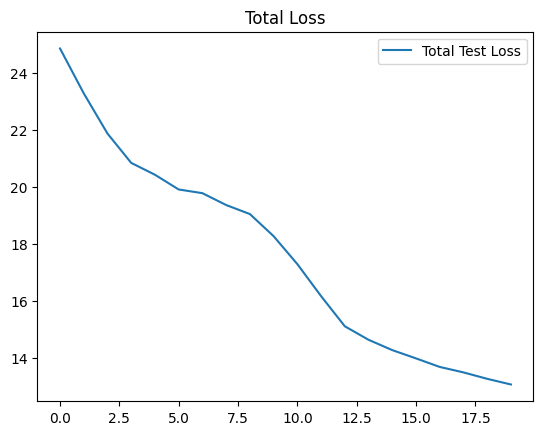

In [23]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [24]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()
    Error_total = F.mse_loss(decoded_x, test_graph.x).detach().cpu().numpy()


    avg1 += Error_wo_s
    avg2+= Error_total

print("Average Error", avg1/len(test_loader))
print("Average Error", avg2/len(test_loader))


Average Error 12.106675585803963
Average Error 12.221124728847071


In [25]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[1][heavy_indices])

16

In [26]:
input_feature[1]

tensor([[-1.5778e+00,  1.3428e+00, -1.1537e+00,  2.3435e+01,  1.5395e+01,
          1.0460e+01],
        [-1.1220e+00,  1.4199e+00, -4.8689e-01,  2.1515e+01,  1.5728e+01,
          8.7550e+00],
        [-1.5353e+00,  3.0201e-01, -1.7435e+00,  2.2578e+01,  1.2803e+01,
          1.0333e+01],
        [-1.4381e+00,  2.0168e-02, -1.7838e+00,  2.3350e+01,  1.5993e+01,
          1.3263e+01],
        [-1.1585e+00,  1.5936e+00, -4.3405e-01,  2.4665e+01,  1.3495e+01,
          7.4925e+00],
        [-1.4487e+00,  6.6293e-01, -1.4049e+00,  2.3380e+01,  1.9070e+01,
          1.2640e+01],
        [-1.4531e+00, -5.0121e-02, -1.8518e+00,  2.6055e+01,  1.8812e+01,
          1.1548e+01],
        [-1.0688e+00,  1.6416e+00, -3.0066e-01,  2.0415e+01,  1.5177e+01,
          1.3765e+01],
        [-1.3095e+00,  1.1489e+00, -9.1305e-01,  2.0455e+01,  1.8608e+01,
          1.1543e+01],
        [-1.7090e+00,  3.9108e-01, -1.9278e+00,  2.0347e+01,  1.2773e+01,
          8.3150e+00],
        [-1.1659e+00,  1.5775e

In [27]:
input_feature[20][heavy_indices]

tensor([[-0.8712,  0.2411, -0.9000, 18.4425,  2.7600, 20.5400],
        [-0.9224,  0.7609, -0.6558, 17.1875,  3.9425, 18.2450],
        [-1.1265, -0.0955, -1.4416, 16.8250,  3.6975, 22.7850],
        [-1.0572,  1.0658, -0.6216, 20.8850,  4.5575, 20.9500],
        [-0.9230,  0.4448, -0.8345, 21.1600,  1.2775, 20.8125],
        [-0.9153,  1.3242, -0.2891, 16.1075,  0.8425, 22.0225],
        [-1.5592, -0.2526, -2.1291, 16.4325,  1.0100, 17.9825],
        [-1.2608, -0.1216, -1.6358, 21.2000,  4.1350, 18.2275],
        [-1.1059,  1.1283, -0.6500, 18.9000,  5.9325, 18.0725],
        [-1.1900,  0.8020, -0.9746, 19.5800,  2.3275, 16.6575],
        [-1.5048,  0.7218, -1.4434, 19.9050,  6.8900, 21.3775],
        [-0.9102,  0.4345, -0.8298, 15.7050,  6.0725, 19.3425],
        [-1.0522,  1.2157, -0.5312, 14.7475,  5.2975, 22.0925],
        [-0.7569,  1.0211, -0.2739, 16.9275,  2.2650, 25.0300],
        [-1.3313,  0.3265, -1.4491, 18.1925,  5.6950, 24.3025],
        [-1.0277,  1.0696, -0.5860, 17.8

In [28]:
decoded_feature[20][heavy_indices]

tensor([[-1.5242,  0.6946, -1.2595, 15.9207,  6.6082, 21.9993],
        [-1.4044,  0.8087, -1.1596, 14.6744,  6.7038, 21.7003],
        [-1.4009,  0.8091, -1.1568, 14.6264,  6.6888, 21.6092],
        [-1.4049,  0.8087, -1.1600, 14.6808,  6.7058, 21.7124],
        [-1.4055,  0.8086, -1.1605, 14.6896,  6.7085, 21.7291],
        [-1.4009,  0.8091, -1.1568, 14.6266,  6.6888, 21.6096],
        [-1.4055,  0.8086, -1.1606, 14.6897,  6.7086, 21.7293],
        [-1.4037,  0.8088, -1.1591, 14.6651,  6.7009, 21.6827],
        [-1.4042,  0.8088, -1.1595, 14.6717,  6.7029, 21.6953],
        [-1.4051,  0.8087, -1.1602, 14.6840,  6.7068, 21.7185],
        [-1.4030,  0.8089, -1.1585, 14.6556,  6.6979, 21.6646],
        [-1.4035,  0.8088, -1.1589, 14.6614,  6.6997, 21.6757],
        [-1.3720,  0.8122, -1.1334, 14.2250,  6.5529, 20.8270],
        [-1.4021,  0.8090, -1.1578, 14.6426,  6.6938, 21.6400],
        [-1.4048,  0.8087, -1.1600, 14.6801,  6.7056, 21.7110],
        [-1.4037,  0.8088, -1.1591, 14.6

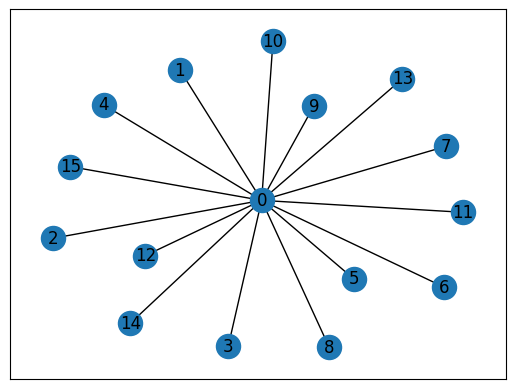

In [29]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()


In [30]:
def plotCompare(features1,features2):
    # %matplotlib widget
    xyz1 = features1[:,-3:]
    xyz2 = features2[:,-3:]
    fig = plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    ax1.scatter(xyz1[:,0],xyz1[:,1],xyz1[:,2],label="output")
    ax1.scatter(xyz2[:,0],xyz2[:,1],xyz2[:,2],label="input")
    plt.legend()
    plt.show()

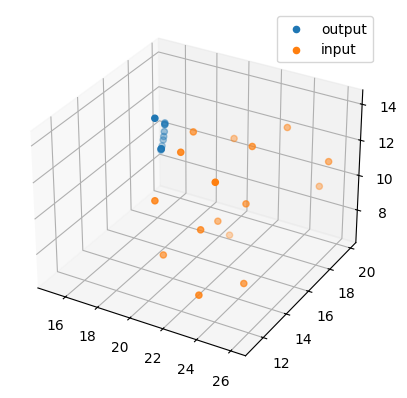

In [31]:
plotCompare(decoded_feature[1].detach().numpy(),input_feature[1].detach().numpy())


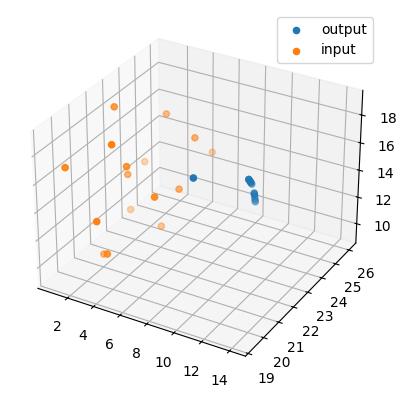

In [32]:
plotCompare(decoded_feature[15].detach().numpy(),input_feature[15].detach().numpy())

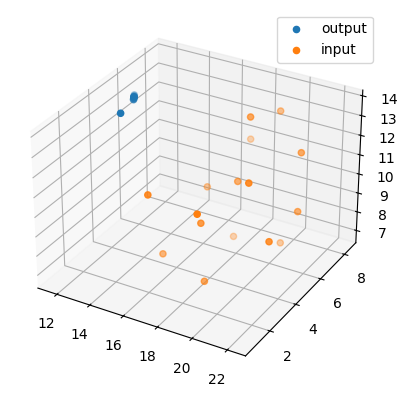

In [33]:
plotCompare(decoded_feature[39].detach().numpy(),input_feature[39].detach().numpy())